## Modeling Objetives

### Introduction

After doing the data cleaning and feature selection. We have decided to test models in order to either predict the average ratings of a book or by doing a classification of the book using engineered features.
It would be interesting too to compare models that predict the initial average rating, when using SMOTE algorithm in order to balance the data.

## Steps to follow

#### 1. Preparing the dataset for regression



In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
#dataset = pd.read_excel('Projet Python simulations.xlsx',sheet_name="Python_Dataset")


In [224]:
# We load the dataset and we check the content and the columns
clean_dataset = pd.read_csv('clean_dataset.csv')
display(clean_dataset.columns)
clean_dataset.head()


Index(['Unnamed: 0', 'bookid', 'title', 'authors', 'average_rating', 'isbn',
       'isbn13', 'language_code', 'num_pages', 'ratings_count',
       'text_reviews_count', 'publication_date', 'publisher', 'title2',
       'author2', 'genre', 'multiple_authors', 'n_authors', 'authors_list',
       'main_author', 'ratings_count_updt', 'text_reviews_count_updt',
       'max_pages', 'total_reviews', 'avg_numpages_author',
       'n_pages_vs_avg_auth', 'avg_numpages_publisher', 'n_pages_vs_avg_pub',
       'avg_rating_author', 'rating_vs_avg_auth', 'avg_rating_publisher',
       'rating_vs_avg_pub', 'rating_vs_avg', 'rating_vs_mode', 'pub_month',
       'pub_year', 'pub_month_text', 'season', 'season_num', 'century',
       'language_code_ENgroup', 'log_ratings_count', 'ratings_count_category',
       'ratings_count_category_T', 'log_text_reviews_count_updt',
       'text_reviews_count_category', 'text_reviews_count_category_T',
       'log_total_reviews', 'total_reviews_category',
       'to

,Unnamed: 0,bookid,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,...,language_code_ENgroup_T,genre_T,num_pages_cat,max_pages_cat,num_pages_cat_T,max_pages_cat_T,average_rating_cat,average_rating_cat_T,average_rating_three_cat,average_rating_three_cat_T
0,1847,6549,said the shotgun to the head.,saul williams,4.22,0743470796,9780743470797,en-us,192,2762,...,7057,59595,low,low,2,2,good,4,high,3.0
1,4072,14490,$30 film school: how to write direct produce...,michael w. dean,3.49,1592000673,9781592000678,eng,528,30,...,7057,70172,high,high,4,4,medium,3,low,1.0
2,1574,5415,'salem's lot,stephen king,4.02,0965772411,9780965772419,eng,405,1039,...,7057,73245,high,high,4,4,good,4,medium,2.0
3,3137,11525,1 000 places to see before you die,patricia schultz,3.85,0761104844,9780761104841,eng,992,36303,...,7057,58063,high,high,4,4,good,4,medium,2.0
4,2343,8542,10 lb penalty,dick francis,3.90,042519745X,9780425197455,eng,320,3490,...,7057,80651,medium,medium,3,3,good,4,medium,2.0


In [227]:
# We will only choose numerical data that is not a transformation using the average ratings and we avoid highly correlated variables
regression_columns = ['average_rating','log_ratings_count', 'log_total_reviews','multiple_authors', 'n_authors', 'max_pages', 'season_num','avg_rating_author','average_rating_three_cat_T']
regression_dataset = clean_dataset[regression_columns]
regression_dataset = regression_dataset[~(regression_dataset['average_rating_three_cat_T'].isna())]
display(regression_dataset.head())

,average_rating,log_ratings_count,log_total_reviews,multiple_authors,n_authors,max_pages,season_num,avg_rating_author,average_rating_three_cat_T
0,4.22,3.441239,3.473648,0,1,192,4,4.22,3.0
1,3.49,1.478566,1.532754,0,1,528,2,3.49,1.0
2,4.02,4.933751,4.937909,0,1,817,4,3.98,2.0
3,3.85,4.559944,4.565164,0,1,992,2,3.85,2.0
4,3.90,3.542838,3.564323,0,1,320,3,3.96,2.0


<AxesSubplot: >

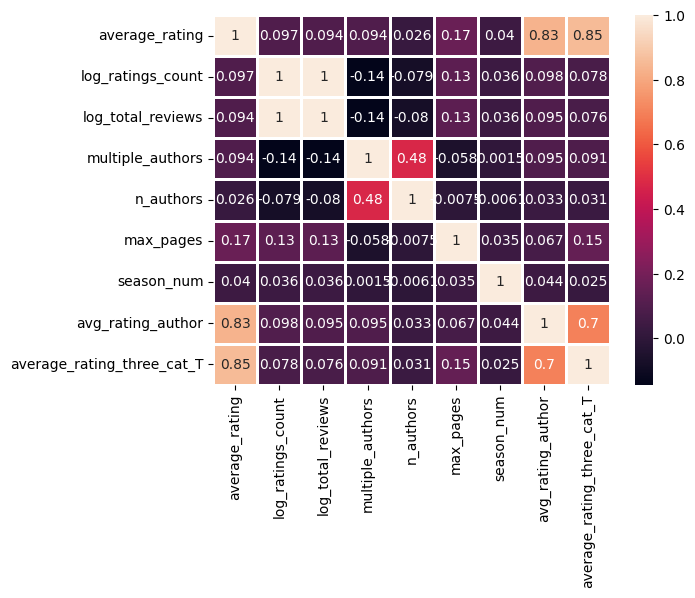

In [228]:
# We observe that average_rating and average_rating_three_cat_T are highly correlated, this is expected as the latter is a transformation of the first into a categorical variable
sns.heatmap(regression_dataset.corr(),annot=True,lw=1)

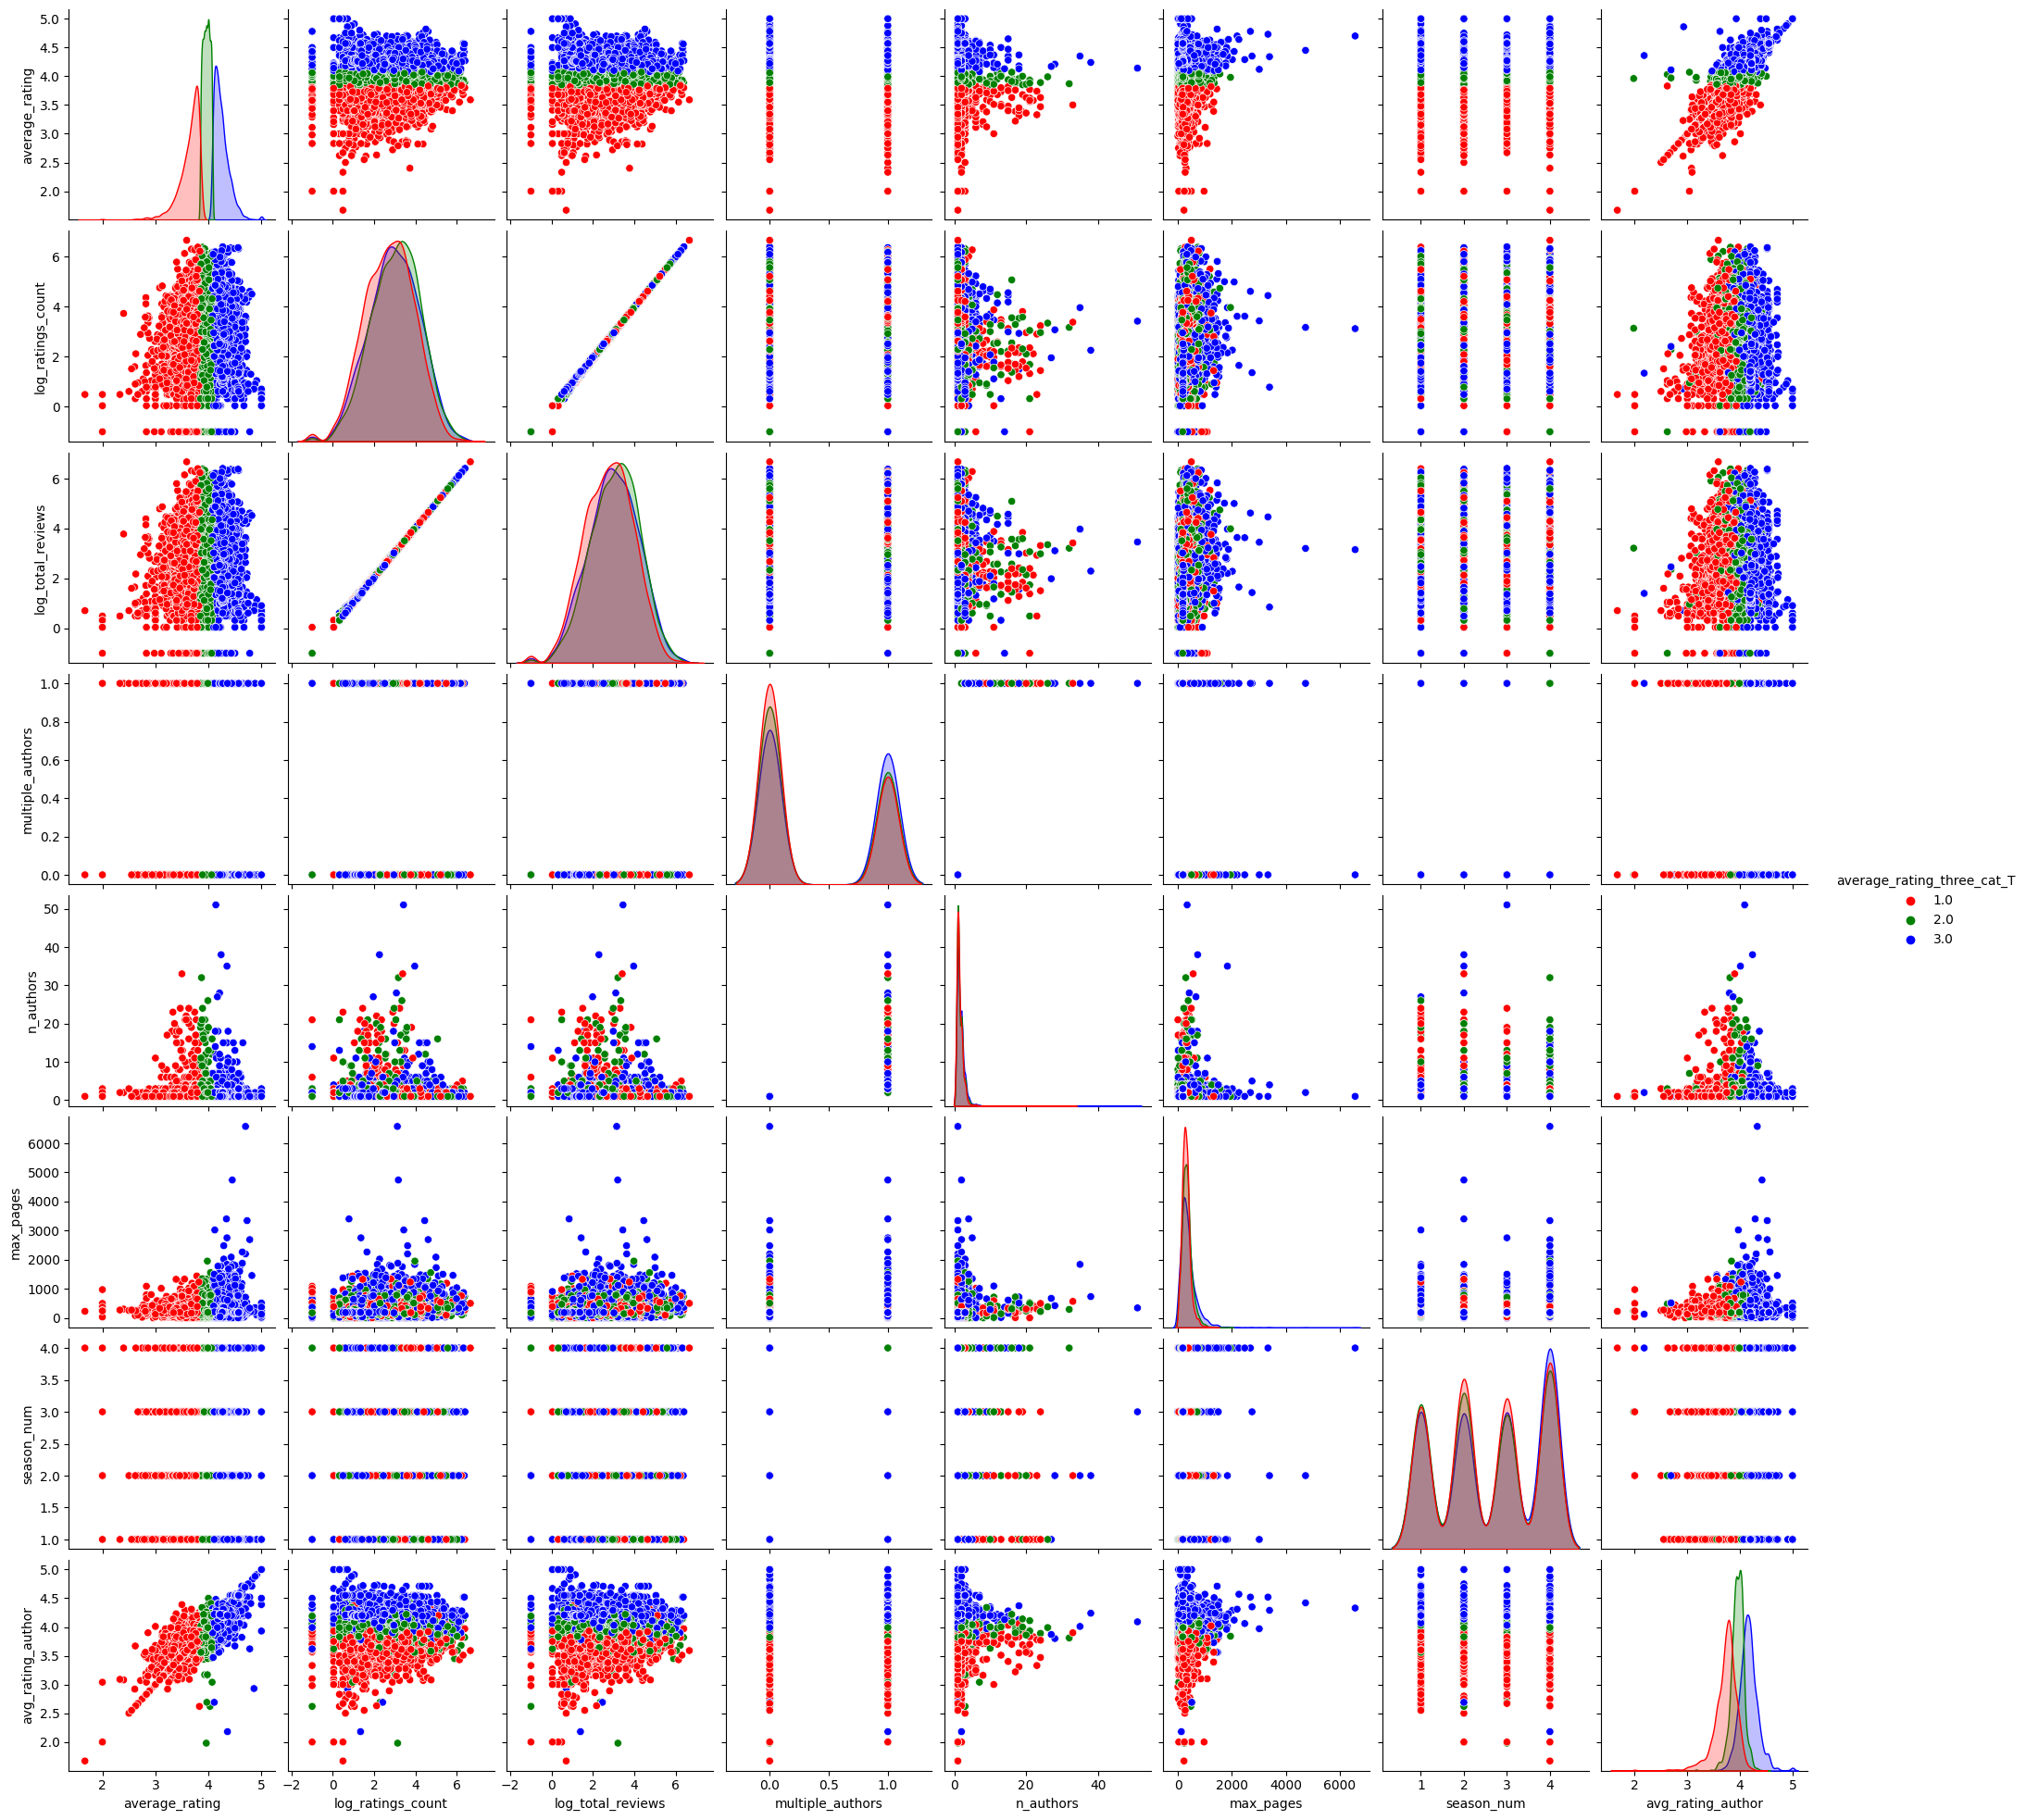

In [229]:
# We observe the distribution of each variable pair by pairs, and we observe the position of our new engineered target category
sns.pairplot(regression_dataset,hue='average_rating_three_cat_T', palette=['r', 'g', 'b'])

In [232]:
# This is a helper function that helps transform categorical data into dummies, to adapt the data for the regression
def from_categoric_to_dummies(columns,dataset):
    dummies = []
    for col in columns:
        dummies.append(pd.get_dummies(dataset[col], prefix=col, prefix_sep='_'))
    new_dataset = pd.concat([dataset, *dummies], axis=1)
    new_dataset = new_dataset.drop(columns, axis=1)
    return new_dataset

In [230]:
#we will create two datasets: one containing the average_ratings and a second containing the transformation of this target column into 3 different categories
regression_dataset_avg_rating_cat = regression_dataset.drop('average_rating', axis=1)
regression_dataset_avg_rating = regression_dataset.drop('average_rating_three_cat_T', axis=1)

In [231]:
# We generate dummies for the categories, pub_month and season_num
regression_dataset_avg_rating_cat = from_categoric_to_dummies(['season_num'],regression_dataset_avg_rating_cat)
regression_dataset_avg_rating = from_categoric_to_dummies(['season_num'],regression_dataset_avg_rating)


## 2. Generating Training and test datasets


For our project we wanted to tackle the problem of predicting the ratings the average ratings of a book from the other parameters we have taken

In [233]:
from sklearn.model_selection import train_test_split

def prepare_dataset_for_linear_regression(dataset,target_column, test_size,dataset_name):
    result = {}
    result['name'] = dataset_name
    df_train, df_test = train_test_split(dataset,test_size = test_size)
    display(len(dataset))
    display(len(df_train))
    display(len(df_test))
    display(regression_dataset.describe())
    display(df_train.describe())
    display(df_test.describe())
    X_train = df_train.drop([target_column], axis=1)
    Y_train = df_train[target_column].values
    X_test = df_test.drop([target_column], axis=1)
    Y_test = df_test[target_column].values
    result['X_train'] = X_train
    result['Y_train'] = Y_train
    result['X_test'] = X_test
    result['Y_test'] = Y_test
    return result
    

In [234]:
display(regression_dataset_avg_rating_cat.head())
display(regression_dataset_avg_rating.head())

,log_ratings_count,log_total_reviews,multiple_authors,n_authors,max_pages,avg_rating_author,average_rating_three_cat_T,season_num_1,season_num_2,season_num_3,season_num_4
0,3.441239,3.473648,0,1,192,4.22,3.0,0,0,0,1
1,1.478566,1.532754,0,1,528,3.49,1.0,0,1,0,0
2,4.933751,4.937909,0,1,817,3.98,2.0,0,0,0,1
3,4.559944,4.565164,0,1,992,3.85,2.0,0,1,0,0
4,3.542838,3.564323,0,1,320,3.96,2.0,0,0,1,0


,average_rating,log_ratings_count,log_total_reviews,multiple_authors,n_authors,max_pages,avg_rating_author,season_num_1,season_num_2,season_num_3,season_num_4
0,4.22,3.441239,3.473648,0,1,192,4.22,0,0,0,1
1,3.49,1.478566,1.532754,0,1,528,3.49,0,1,0,0
2,4.02,4.933751,4.937909,0,1,817,3.98,0,0,0,1
3,3.85,4.559944,4.565164,0,1,992,3.85,0,1,0,0
4,3.90,3.542838,3.564323,0,1,320,3.96,0,0,1,0


In [235]:
regression_dataset_avg_rating_cat_dict = prepare_dataset_for_linear_regression(regression_dataset_avg_rating_cat,'average_rating_three_cat_T',0.2,'Regression using Average Rating Category')
regression_dataset_avg_rating_dict = prepare_dataset_for_linear_regression(regression_dataset_avg_rating,'average_rating',0.2,'Regression using Average Rating Category')

10281

8224

2057

,average_rating,log_ratings_count,log_total_reviews,multiple_authors,n_authors,max_pages,season_num,avg_rating_author,average_rating_three_cat_T
count,10281.000000,10281.000000,10281.000000,10281.000000,10281.000000,10281.000000,10281.000000,10281.000000,10281.000000
mean,3.942800,2.908658,2.938936,0.398016,1.712966,338.565898,2.602471,3.941095,1.990857
std,0.297308,1.207651,1.198812,0.489513,1.842272,239.349215,1.138737,0.255341,0.819102
min,1.670000,-1.000000,-1.000000,0.000000,1.000000,1.000000,1.000000,1.670000,1.000000
25%,3.770000,2.057286,2.100715,0.000000,1.000000,199.000000,2.000000,3.800000,1.000000
50%,3.960000,2.947483,2.975937,0.000000,1.000000,301.000000,3.000000,3.950000,2.000000
75%,4.140000,3.768053,3.788953,1.000000,2.000000,416.000000,4.000000,4.090000,3.000000
max,5.000000,6.662537,6.671352,1.000000,51.000000,6576.000000,4.000000,5.000000,3.000000


,log_ratings_count,log_total_reviews,multiple_authors,n_authors,max_pages,avg_rating_author,average_rating_three_cat_T,season_num_1,season_num_2,season_num_3,season_num_4
count,8224.000000,8224.000000,8224.000000,8224.000000,8224.000000,8224.000000,8224.000000,8224.000000,8224.000000,8224.000000,8224.000000
mean,2.909259,2.939687,0.398103,1.711333,337.245623,3.941525,2.003161,0.227262,0.243312,0.224951,0.304475
std,1.209976,1.200799,0.489537,1.851954,232.243971,0.258928,0.820798,0.419088,0.429108,0.417576,0.460213
min,-1.000000,-1.000000,0.000000,1.000000,1.000000,1.670000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2.068557,2.110926,0.000000,1.000000,198.000000,3.800000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,2.936815,2.965484,0.000000,1.000000,299.000000,3.960000,2.000000,0.000000,0.000000,0.000000,0.000000
75%,3.767701,3.786226,1.000000,2.000000,416.000000,4.100000,3.000000,0.000000,0.000000,0.000000,1.000000
max,6.662537,6.671352,1.000000,51.000000,4736.000000,5.000000,3.000000,1.000000,1.000000,1.000000,1.000000


,log_ratings_count,log_total_reviews,multiple_authors,n_authors,max_pages,avg_rating_author,average_rating_three_cat_T,season_num_1,season_num_2,season_num_3,season_num_4
count,2057.000000,2057.000000,2057.000000,2057.000000,2057.000000,2057.000000,2057.000000,2057.000000,2057.000000,2057.000000,2057.000000
mean,2.906255,2.935933,0.397667,1.719494,343.844434,3.939378,1.941663,0.223627,0.259115,0.225085,0.292173
std,1.198601,1.191120,0.489535,1.803470,265.861936,0.240522,0.810618,0.416776,0.438256,0.417740,0.454872
min,-1.000000,-1.000000,0.000000,1.000000,1.000000,2.620000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2.025715,2.068557,0.000000,1.000000,200.000000,3.800000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,2.992598,3.012458,0.000000,1.000000,304.000000,3.940000,2.000000,0.000000,0.000000,0.000000,0.000000
75%,3.770049,3.801411,1.000000,2.000000,416.000000,4.080000,3.000000,0.000000,1.000000,0.000000,1.000000
max,6.309112,6.314692,1.000000,27.000000,6576.000000,5.000000,3.000000,1.000000,1.000000,1.000000,1.000000


10281

8224

2057

,average_rating,log_ratings_count,log_total_reviews,multiple_authors,n_authors,max_pages,season_num,avg_rating_author,average_rating_three_cat_T
count,10281.000000,10281.000000,10281.000000,10281.000000,10281.000000,10281.000000,10281.000000,10281.000000,10281.000000
mean,3.942800,2.908658,2.938936,0.398016,1.712966,338.565898,2.602471,3.941095,1.990857
std,0.297308,1.207651,1.198812,0.489513,1.842272,239.349215,1.138737,0.255341,0.819102
min,1.670000,-1.000000,-1.000000,0.000000,1.000000,1.000000,1.000000,1.670000,1.000000
25%,3.770000,2.057286,2.100715,0.000000,1.000000,199.000000,2.000000,3.800000,1.000000
50%,3.960000,2.947483,2.975937,0.000000,1.000000,301.000000,3.000000,3.950000,2.000000
75%,4.140000,3.768053,3.788953,1.000000,2.000000,416.000000,4.000000,4.090000,3.000000
max,5.000000,6.662537,6.671352,1.000000,51.000000,6576.000000,4.000000,5.000000,3.000000


,average_rating,log_ratings_count,log_total_reviews,multiple_authors,n_authors,max_pages,avg_rating_author,season_num_1,season_num_2,season_num_3,season_num_4
count,8224.000000,8224.000000,8224.000000,8224.000000,8224.000000,8224.000000,8224.000000,8224.000000,8224.000000,8224.000000,8224.000000
mean,3.942256,2.913681,2.943963,0.398103,1.708901,336.876702,3.939242,0.223371,0.244042,0.225316,0.307271
std,0.297675,1.208455,1.199689,0.489537,1.843873,241.845480,0.256025,0.416530,0.429544,0.417816,0.461391
min,1.670000,-1.000000,-1.000000,0.000000,1.000000,1.000000,1.670000,0.000000,0.000000,0.000000,0.000000
25%,3.770000,2.063893,2.106698,0.000000,1.000000,197.000000,3.800000,0.000000,0.000000,0.000000,0.000000
50%,3.960000,2.949439,2.976854,0.000000,1.000000,300.000000,3.950000,0.000000,0.000000,0.000000,0.000000
75%,4.140000,3.770215,3.792136,1.000000,2.000000,413.000000,4.090000,0.000000,0.000000,0.000000,1.000000
max,5.000000,6.662537,6.671352,1.000000,51.000000,6576.000000,5.000000,1.000000,1.000000,1.000000,1.000000


,average_rating,log_ratings_count,log_total_reviews,multiple_authors,n_authors,max_pages,avg_rating_author,season_num_1,season_num_2,season_num_3,season_num_4
count,2057.000000,2057.000000,2057.000000,2057.000000,2057.000000,2057.000000,2057.000000,2057.000000,2057.000000,2057.000000,2057.000000
mean,3.944978,2.888575,2.918839,0.397667,1.729217,345.319397,3.948503,0.239183,0.256198,0.223627,0.280992
std,0.295896,1.204514,1.195378,0.489535,1.836213,229.029892,0.252514,0.426689,0.436639,0.416776,0.449593
min,2.400000,-1.000000,-1.000000,0.000000,1.000000,1.000000,2.500000,0.000000,0.000000,0.000000,0.000000
25%,3.770000,2.045714,2.083144,0.000000,1.000000,207.000000,3.810000,0.000000,0.000000,0.000000,0.000000
50%,3.960000,2.937568,2.972249,0.000000,1.000000,304.000000,3.960000,0.000000,0.000000,0.000000,0.000000
75%,4.140000,3.752287,3.777579,1.000000,2.000000,420.000000,4.100000,0.000000,1.000000,0.000000,1.000000
max,5.000000,5.798542,5.809435,1.000000,27.000000,3020.000000,5.000000,1.000000,1.000000,1.000000,1.000000


In [236]:
regression_dataset_avg_rating_cat_dict

{'name': 'Regression using Average Rating Category',
 'X_train':        log_ratings_count  log_total_reviews  multiple_authors  n_authors  \
 10159           1.363612           1.399674                 0          1   
 9556            2.100715           2.182129                 1          2   
 2938            2.485863           2.532882                 0          1   
 9371            2.243286           2.265054                 1          3   
 3832            4.195349           4.224121                 0          1   
 ...                  ...                ...               ...        ...   
 6966            4.482889           4.493097                 0          1   
 2639            3.328808           3.354896                 0          1   
 4692            3.078493           3.116641                 0          1   
 6234            1.545307           1.545307                 0          1   
 5442            0.041393           0.041393                 1          2   
 
        ma

## Regression Algorithms

For Prediction of a variable

1. Ordinary Least Squares (Classic way of fitting data with a linear model)
2. Bayesian Regression (It uses random variables to obtain a fully probabilistic model, where the output is assumed to be Gaussian distributed around Xw)

For Classification Purposes:
3. Random Forest
4. AdaBoost


## Ordinary Least Squares

In [237]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [238]:
def perform_linear_regression(X_train, Y_train, X_test, Y_test, dataset_name,model_name='Linear Regression', model=linear_model.LinearRegression()):
    # Create linear regression object
    regr = model

    # Train the model using the training sets
    regr.fit(X_train, Y_train)

    # Make predictions using the testing set
    Y_pred = regr.predict(X_test)

    # The coefficients
    print("Coefficients: \n", regr.coef_)
    # The mean squared error
    print("Mean squared error: %.2f" % mean_squared_error(Y_test, Y_pred))
    # The coefficient of determination: 1 is perfect prediction
    print("Coefficient of determination: %.2f" % r2_score(Y_test, Y_pred))

    # print the intercept
    print(regr.intercept_)
    coeff_parameter = pd.DataFrame(regr.coef_,X_train.columns,columns=['Coefficient'])
    display(coeff_parameter)

    pred_fig = sns.regplot(x=Y_test,y=Y_pred)
    pred_fig.set(xlabel ="Y_test", ylabel = "Y_pred", title =f'{dataset_name} \n Model: {model_name} \n Predicted Y vs Testing Y'.format(dataset_name=dataset_name,model_name=model_name))

    return {'model' : regr, 'Y_pred': Y_pred, 'Coefficients_dataset' : coeff_parameter}


In [239]:
regression_dataset_avg_rating_cat_dict
regression_dataset_avg_rating_dict

{'name': 'Regression using Average Rating Category',
 'X_train':       log_ratings_count  log_total_reviews  multiple_authors  n_authors  \
 9448           3.598254           3.600984                 0          1   
 3597           3.956989           3.971698                 0          1   
 3125           2.267406           2.309843                 0          1   
 3422           2.301247           2.340642                 0          1   
 2414           2.193403           2.245759                 1          3   
 ...                 ...                ...               ...        ...   
 832            3.632872           3.645137                 1          2   
 50             4.118830           4.141045                 0          1   
 9649           4.615278           4.634136                 0          1   
 1157           1.806858           1.833147                 1          3   
 3205           3.851081           3.868592                 1          2   
 
       max_pages  avg_

Coefficients: 
 [ 3.06047985e-01 -3.09006474e-01  6.45919165e-02 -2.27051931e-03
  4.05964967e-04  2.16644942e+00  2.53276132e-02 -3.60626229e-03
 -1.65087179e-02 -5.21263299e-03]
Mean squared error: 0.32
Coefficient of determination: 0.51
-6.676259363616144


,Coefficient
log_ratings_count,0.306048
log_total_reviews,-0.309006
multiple_authors,0.064592
n_authors,-0.002271
max_pages,0.000406
avg_rating_author,2.166449
season_num_1,0.025328
season_num_2,-0.003606
season_num_3,-0.016509
season_num_4,-0.005213


{'model': LinearRegression(),
 'Y_pred': array([2.03059161, 1.41591966, 2.11172753, ..., 2.39791688, 2.27651942,
        2.18939138]),
 'Coefficients_dataset':                    Coefficient
 log_ratings_count     0.306048
 log_total_reviews    -0.309006
 multiple_authors      0.064592
 n_authors            -0.002271
 max_pages             0.000406
 avg_rating_author     2.166449
 season_num_1          0.025328
 season_num_2         -0.003606
 season_num_3         -0.016509
 season_num_4         -0.005213}

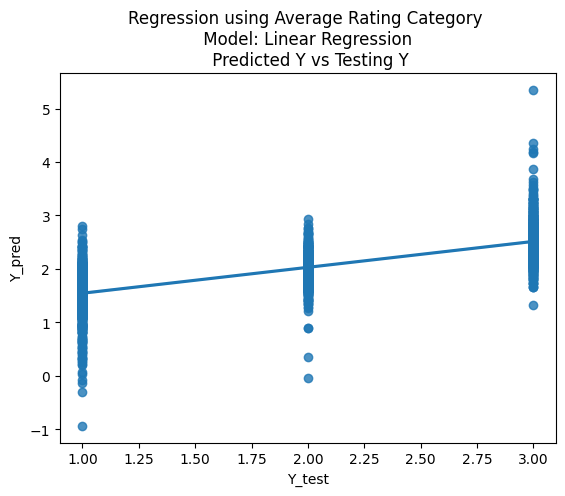

In [240]:
perform_linear_regression(regression_dataset_avg_rating_cat_dict['X_train'],regression_dataset_avg_rating_cat_dict['Y_train'],regression_dataset_avg_rating_cat_dict['X_test'], regression_dataset_avg_rating_cat_dict['Y_test'],regression_dataset_avg_rating_cat_dict['name'])

Coefficients: 
 [ 3.96308308e-01 -3.97975478e-01  1.94531122e-02 -2.37271202e-03
  1.31692451e-04  9.51279657e-01 -1.79044725e-04 -1.30837907e-03
  9.23790658e-04  5.63633137e-04]
Mean squared error: 0.02
Coefficient of determination: 0.72
0.16376769344148157


,Coefficient
log_ratings_count,0.396308
log_total_reviews,-0.397975
multiple_authors,0.019453
n_authors,-0.002373
max_pages,0.000132
avg_rating_author,0.951280
season_num_1,-0.000179
season_num_2,-0.001308
season_num_3,0.000924
season_num_4,0.000564


{'model': LinearRegression(),
 'Y_pred': array([3.91592557, 3.3327581 , 3.82574591, ..., 3.76602365, 4.16147323,
        3.92677155]),
 'Coefficients_dataset':                    Coefficient
 log_ratings_count     0.396308
 log_total_reviews    -0.397975
 multiple_authors      0.019453
 n_authors            -0.002373
 max_pages             0.000132
 avg_rating_author     0.951280
 season_num_1         -0.000179
 season_num_2         -0.001308
 season_num_3          0.000924
 season_num_4          0.000564}

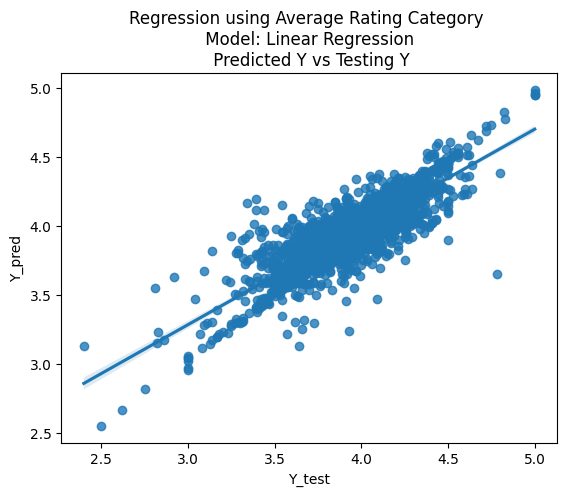

In [241]:
perform_linear_regression(regression_dataset_avg_rating_dict['X_train'],regression_dataset_avg_rating_dict['Y_train'],regression_dataset_avg_rating_dict['X_test'], regression_dataset_avg_rating_dict['Y_test'],regression_dataset_avg_rating_dict['name'])

Coefficients: 
 [ 3.12903891e-01 -3.15949606e-01  6.47165925e-02 -2.29886165e-03
  4.05839566e-04  2.16274784e+00 -6.63579918e+00 -6.66478680e+00
 -6.67760239e+00 -6.66624328e+00]
Mean squared error: 0.32
Coefficient of determination: 0.51
0.0


,Coefficient
log_ratings_count,0.312904
log_total_reviews,-0.315950
multiple_authors,0.064717
n_authors,-0.002299
max_pages,0.000406
avg_rating_author,2.162748
season_num_1,-6.635799
season_num_2,-6.664787
season_num_3,-6.677602
season_num_4,-6.666243


{'model': BayesianRidge(compute_score=True, fit_intercept=False, tol=1e-06),
 'Y_pred': array([2.03077294, 1.41674451, 2.11206508, ..., 2.39779483, 2.27628362,
        2.18914748]),
 'Coefficients_dataset':                    Coefficient
 log_ratings_count     0.312904
 log_total_reviews    -0.315950
 multiple_authors      0.064717
 n_authors            -0.002299
 max_pages             0.000406
 avg_rating_author     2.162748
 season_num_1         -6.635799
 season_num_2         -6.664787
 season_num_3         -6.677602
 season_num_4         -6.666243}

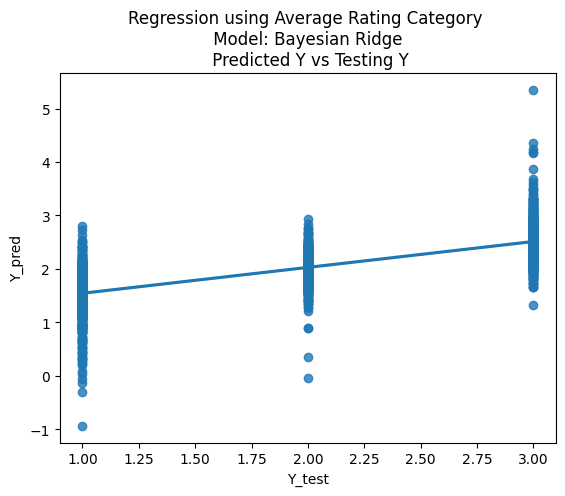

In [242]:
from sklearn.linear_model import BayesianRidge

reg = BayesianRidge(tol=1e-6, fit_intercept=False, compute_score=True)
perform_linear_regression(regression_dataset_avg_rating_cat_dict['X_train'],regression_dataset_avg_rating_cat_dict['Y_train'],regression_dataset_avg_rating_cat_dict['X_test'], regression_dataset_avg_rating_cat_dict['Y_test'],regression_dataset_avg_rating_cat_dict['name'], model_name='Bayesian Ridge',model=reg)


Coefficients: 
 [ 3.63226480e-01 -3.64645841e-01  1.94471297e-02 -2.35946217e-03
  1.31935145e-04  9.52206214e-01  1.58094838e-01  1.56978984e-01
  1.59212815e-01  1.58799081e-01]
Mean squared error: 0.02
Coefficient of determination: 0.72
0.0


,Coefficient
log_ratings_count,0.363226
log_total_reviews,-0.364646
multiple_authors,0.019447
n_authors,-0.002359
max_pages,0.000132
avg_rating_author,0.952206
season_num_1,0.158095
season_num_2,0.156979
season_num_3,0.159213
season_num_4,0.158799


{'model': BayesianRidge(compute_score=True, fit_intercept=False, tol=1e-06),
 'Y_pred': array([3.91709125, 3.33300935, 3.82563313, ..., 3.7649985 , 4.161126  ,
        3.92728999]),
 'Coefficients_dataset':                    Coefficient
 log_ratings_count     0.363226
 log_total_reviews    -0.364646
 multiple_authors      0.019447
 n_authors            -0.002359
 max_pages             0.000132
 avg_rating_author     0.952206
 season_num_1          0.158095
 season_num_2          0.156979
 season_num_3          0.159213
 season_num_4          0.158799}

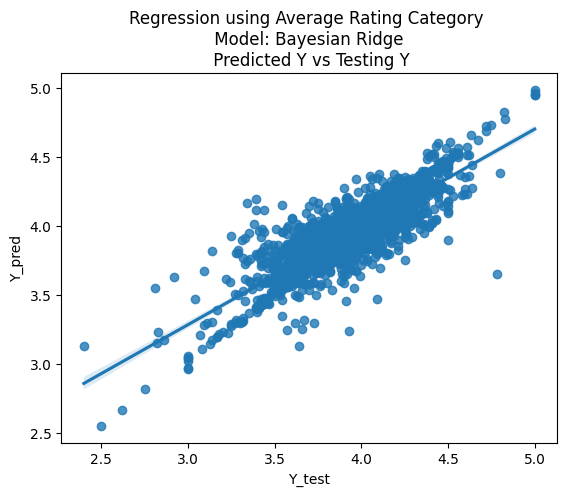

In [243]:
perform_linear_regression(regression_dataset_avg_rating_dict['X_train'],regression_dataset_avg_rating_dict['Y_train'],regression_dataset_avg_rating_dict['X_test'], regression_dataset_avg_rating_dict['Y_test'],regression_dataset_avg_rating_dict['name'], model_name='Bayesian Ridge',model=reg)

## Classification
3. Random Forest
4. AdaBoost


In [244]:
featured_columns = ['language_code', 'genre', 'multiple_authors', 'n_authors', 'max_pages','avg_rating_author', 'pub_month',
       'pub_year', 'season_num', 'log_ratings_count', 'ratings_count_category','log_total_reviews', 'average_rating_three_cat_T']


In [245]:

classification_dataset = clean_dataset[featured_columns]

display(classification_dataset.head())

,language_code,genre,multiple_authors,n_authors,max_pages,avg_rating_author,pub_month,pub_year,season_num,log_ratings_count,ratings_count_category,log_total_reviews,average_rating_three_cat_T
0,en-us,food,0,1,192,4.22,9,2003,4,3.441239,medium high,3.473648,3.0
1,eng,art,0,1,528,3.49,5,2003,2,1.478566,low,1.532754,1.0
2,eng,autobiography-biography,0,1,817,3.98,10,1975,4,4.933751,high,4.937909,2.0
3,eng,guidebook,0,1,992,3.85,5,2003,2,4.559944,high,4.565164,2.0
4,eng,mystery,0,1,320,3.96,8,2004,3,3.542838,medium high,3.564323,2.0


In [246]:
classification_dataset = classification_dataset.dropna()

classification_dataset_dummies = from_categoric_to_dummies(['language_code','genre','pub_month','season_num','ratings_count_category'],classification_dataset)
classification_dataset_dummies.columns


Index(['multiple_authors', 'n_authors', 'max_pages', 'avg_rating_author',
       'pub_year', 'log_ratings_count', 'log_total_reviews',
       'average_rating_three_cat_T', 'language_code_ara',
       'language_code_en-ca', 'language_code_en-gb', 'language_code_en-us',
       'language_code_eng', 'language_code_enm', 'language_code_fre',
       'language_code_ger', 'language_code_gla', 'language_code_glg',
       'language_code_grc', 'language_code_ita', 'language_code_jpn',
       'language_code_lat', 'language_code_msa', 'language_code_mul',
       'language_code_nl', 'language_code_nor', 'language_code_por',
       'language_code_rus', 'language_code_spa', 'language_code_swe',
       'language_code_tur', 'language_code_wel', 'language_code_zho',
       'genre_action-adventure', 'genre_art', 'genre_autobiography-biography',
       'genre_business-economy', 'genre_comics', 'genre_drama', 'genre_essay',
       'genre_fable-fairytale', 'genre_fantasy', 'genre_fiction', 'genre_food',
    

In [247]:

classification_dataset_cat_dict = prepare_dataset_for_linear_regression(classification_dataset_dummies,'average_rating_three_cat_T',0.2,'Classification - Featured Engineered')


10281

8224

2057

,average_rating,log_ratings_count,log_total_reviews,multiple_authors,n_authors,max_pages,season_num,avg_rating_author,average_rating_three_cat_T
count,10281.000000,10281.000000,10281.000000,10281.000000,10281.000000,10281.000000,10281.000000,10281.000000,10281.000000
mean,3.942800,2.908658,2.938936,0.398016,1.712966,338.565898,2.602471,3.941095,1.990857
std,0.297308,1.207651,1.198812,0.489513,1.842272,239.349215,1.138737,0.255341,0.819102
min,1.670000,-1.000000,-1.000000,0.000000,1.000000,1.000000,1.000000,1.670000,1.000000
25%,3.770000,2.057286,2.100715,0.000000,1.000000,199.000000,2.000000,3.800000,1.000000
50%,3.960000,2.947483,2.975937,0.000000,1.000000,301.000000,3.000000,3.950000,2.000000
75%,4.140000,3.768053,3.788953,1.000000,2.000000,416.000000,4.000000,4.090000,3.000000
max,5.000000,6.662537,6.671352,1.000000,51.000000,6576.000000,4.000000,5.000000,3.000000


,multiple_authors,n_authors,max_pages,avg_rating_author,pub_year,log_ratings_count,log_total_reviews,average_rating_three_cat_T,language_code_ara,language_code_en-ca,...,season_num_1,season_num_2,season_num_3,season_num_4,ratings_count_category_high,ratings_count_category_low,ratings_count_category_medium,ratings_count_category_medium high,ratings_count_category_very high,ratings_count_category_very low
count,8224.000000,8224.000000,8224.000000,8224.000000,8224.000000,8224.000000,8224.000000,8224.000000,8224.000000,8224.000000,...,8224.000000,8224.000000,8224.000000,8224.000000,8224.000000,8224.000000,8224.000000,8224.000000,8224.000000,8224.000000
mean,0.399441,1.717777,340.870258,3.941285,1999.952456,2.904809,2.935063,1.991124,0.000122,0.000851,...,0.224465,0.250730,0.222519,0.302286,0.153089,0.174489,0.287087,0.296085,0.032101,0.057150
std,0.489813,1.809953,244.326295,0.255765,8.374347,1.196843,1.187931,0.820534,0.011027,0.029164,...,0.417255,0.433459,0.415963,0.459276,0.360095,0.379553,0.452430,0.456557,0.176279,0.232143
min,0.000000,1.000000,1.000000,1.670000,1914.000000,-1.000000,-1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,200.000000,3.800000,1998.000000,2.072250,2.117603,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,303.000000,3.950000,2002.000000,2.941313,2.969463,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,2.000000,416.000000,4.090000,2005.000000,3.754929,3.776581,3.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
max,1.000000,38.000000,6576.000000,5.000000,2020.000000,6.662537,6.671352,3.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


,multiple_authors,n_authors,max_pages,avg_rating_author,pub_year,log_ratings_count,log_total_reviews,average_rating_three_cat_T,language_code_ara,language_code_en-ca,...,season_num_1,season_num_2,season_num_3,season_num_4,ratings_count_category_high,ratings_count_category_low,ratings_count_category_medium,ratings_count_category_medium high,ratings_count_category_very high,ratings_count_category_very low
count,2057.000000,2057.000000,2057.000000,2057.000000,2057.000000,2057.000000,2057.000000,2057.000000,2057.0,2057.0,...,2057.000000,2057.000000,2057.000000,2057.000000,2057.000000,2057.000000,2057.000000,2057.000000,2057.000000,2057.000000
mean,0.392319,1.693729,329.352941,3.940335,2000.038892,2.924046,2.954419,1.989791,0.0,0.0,...,0.234808,0.229460,0.234808,0.300924,0.170637,0.185707,0.264463,0.275644,0.042781,0.060768
std,0.488386,1.966530,218.132425,0.253701,8.405890,1.250110,1.241537,0.813548,0.0,0.0,...,0.423982,0.420588,0.423982,0.458771,0.376283,0.388965,0.441154,0.446947,0.202412,0.238963
min,0.000000,1.000000,1.000000,2.000000,1900.000000,-1.000000,-1.000000,1.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,192.000000,3.810000,1998.000000,2.009026,2.053463,1.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,298.000000,3.960000,2003.000000,2.967595,2.993921,2.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,2.000000,413.000000,4.090000,2005.000000,3.841053,3.864754,3.000000,0.0,0.0,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
max,1.000000,51.000000,2198.000000,5.000000,2018.000000,6.403274,6.408878,3.000000,0.0,0.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<AxesSubplot: >

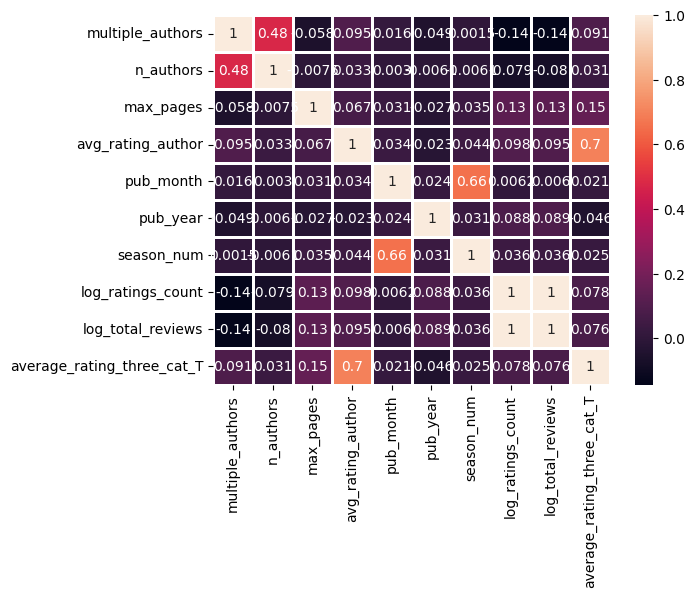

In [248]:
# We observe that average_rating and average_rating_three_cat_T are highly correlated, this is expected as the latter is a transformation of the first into a categorical variable
sns.heatmap(classification_dataset.corr(),annot=True,lw=1)

In [249]:
classification_dataset.isnull().values.any()
classification_dataset.isnull().sum().sum()

0

In [250]:
classification_dataset_cat_dict

{'name': 'Classification - Featured Engineered',
 'X_train':       multiple_authors  n_authors  max_pages  avg_rating_author  pub_year  \
 7635                 1          2        512               4.37      1980   
 6411                 0          1        348               3.83      2002   
 3715                 1          2        240               3.82      2006   
 6377                 1          2        224               3.92      2001   
 1423                 1          4        144               3.93      2005   
 ...                ...        ...        ...                ...       ...   
 7255                 0          1        256               4.05      2004   
 7283                 0          1        349               3.70      2006   
 7043                 1          2          7               4.16      2006   
 6706                 0          1        333               4.35      2005   
 5090                 1          2        242               4.02      2006   
 
  

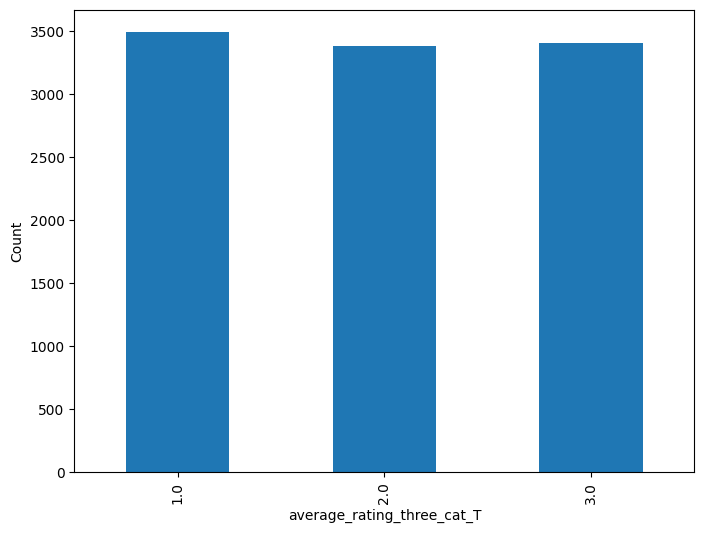

In [251]:
fig, ax = plt.subplots(figsize=(8,6))
classification_dataset_dummies.groupby(['average_rating_three_cat_T'])['average_rating_three_cat_T'].count().plot(kind='bar')
#plt.xticks([0,1],['Legal (0)','Fraud (1)'], rotation=0)
plt.ylabel('Count')
plt.show()

In [252]:
from sklearn.manifold import TSNE
X = classification_dataset_dummies.loc[:, classification_dataset_dummies.columns != 'average_rating_three_cat_T']
y = classification_dataset_dummies.loc[:, classification_dataset_dummies.columns == 'average_rating_three_cat_T']

X = X.to_numpy()
y = y.to_numpy()
y = y.T[0]

tsne = TSNE(n_components=2, random_state=np.random.randint(100))
matrix_2d = tsne.fit_transform(X)

colors = []
for i in y:
    if i == 1.0:
        colors.append('R')
    elif i == 2.0:
        colors.append('B')
    else:
        colors.append('G')


df_tsne = pd.DataFrame(matrix_2d)
df_tsne['average_rating_three_cat_T'] = classification_dataset_dummies['average_rating_three_cat_T']
df_tsne['color'] = colors
df_tsne.columns = ['x','y','average_rating_three_cat_T','color']
cols = ['average_rating_three_cat_T','color','x','y']
df_tsne = df_tsne[cols]
df_tsne.head()

,average_rating_three_cat_T,color,x,y
0,3.0,G,-28.381346,-54.614647
1,1.0,R,56.742321,-6.616634
2,2.0,B,79.067581,29.682243
3,2.0,B,101.184998,19.396847
4,2.0,B,7.568634,-33.525539


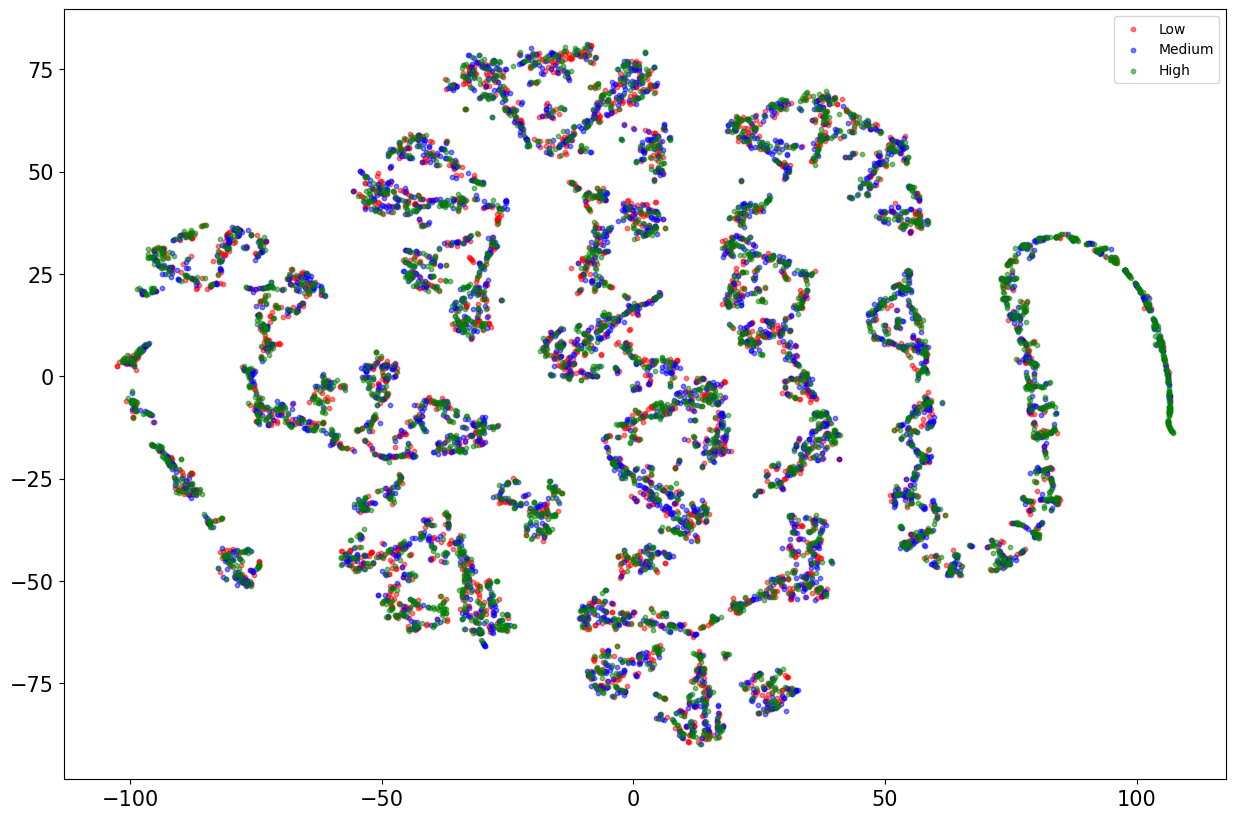

In [253]:
fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(df_tsne[df_tsne['average_rating_three_cat_T']==1.0].x.values, df_tsne[df_tsne['average_rating_three_cat_T']==1.0].y.values,
           c='red', s=10, alpha=0.5, label='Low')
ax.scatter(df_tsne[df_tsne['average_rating_three_cat_T']==2.0].x.values, df_tsne[df_tsne['average_rating_three_cat_T']==2.0].y.values,
           c='blue', s=10, alpha=0.5, label='Medium')
ax.scatter(df_tsne[df_tsne['average_rating_three_cat_T']==3.0].x.values, df_tsne[df_tsne['average_rating_three_cat_T']==3.0].y.values,
           c='green', s=10, alpha=0.5, label='High')
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend()
plt.show()

In [254]:
np.logspace(start=1,stop=3.478,num=20)

array([  10.        ,   13.50271349,   18.23232716,   24.618589  ,
         33.24177538,   44.88541688,   60.60749241,   81.83656055,
        110.50156302,  149.20709458,  201.47006489,  272.03925633,
        367.32681366,  495.99087224,  669.72226422,  904.30678524,
       1221.05954293, 1648.76171638, 2226.27570716, 3006.07630263])

In [255]:
classification_dataset_cat_dict.keys()
X_train = classification_dataset_cat_dict['X_train']
y_train = classification_dataset_cat_dict['Y_train']
X_test = classification_dataset_cat_dict['X_test']
y_test = classification_dataset_cat_dict['Y_test']



In [256]:
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,\
roc_auc_score,roc_curve,recall_score,precision_score,classification_report,f1_score
from sklearn.model_selection import cross_val_score

scores_dict = {num_trees:[] for num_trees in np.logspace(start=1,stop=3.478,num=20).astype(int)}
oob_err_dict = {num_trees:0 for num_trees in np.logspace(start=1,stop=3.478,num=20).astype(int)}
k = 10
for num_trees in np.logspace(start=1,stop=3.478,num=20).astype(int):
    warnings.filterwarnings("ignore")
    clf = RandomForestClassifier(n_estimators=num_trees, n_jobs=-1, max_depth=10, oob_score=True)
    scores = cross_val_score(clf, X_train, y_train, cv=k, n_jobs=-1)
    model = clf.fit(X_train, y_train)
    preds = model.predict(X_test)
    precision = precision_score(y_test, preds, average="micro")
    recall = recall_score(y_test, preds, average="micro")
    f1 = f1_score(y_test, preds, average="micro")
    scores_dict[num_trees].append([scores.mean(), precision, recall, f1])
    temp_oob = 1 - clf.oob_score_
    oob_err_dict[num_trees] = temp_oob

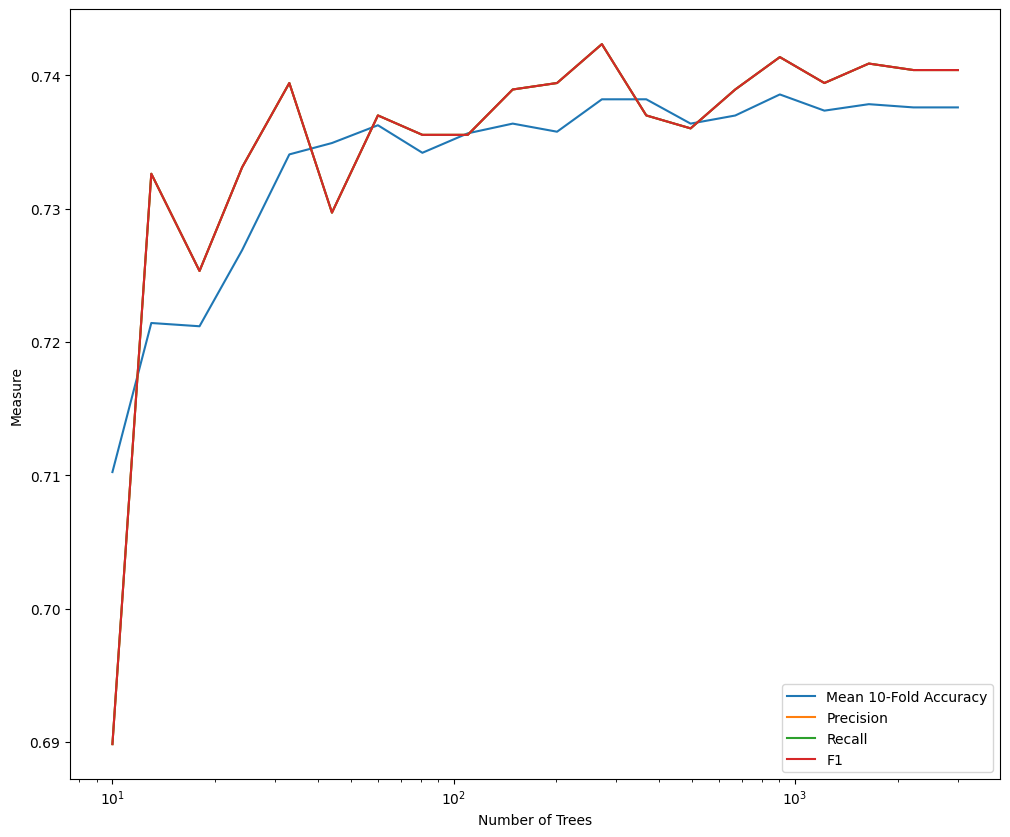

In [266]:
fig, ax = plt.subplots(figsize=(12,10))
ax.semilogx(list(scores_dict.keys()),[elem[0][0] for elem in scores_dict.values()], '-', label='Mean 10-Fold Accuracy')
ax.semilogx(list(scores_dict.keys()),[elem[0][1] for elem in scores_dict.values()], '-', label='Precision')
ax.semilogx(list(scores_dict.keys()),[elem[0][2] for elem in scores_dict.values()], '-', label='Recall')
ax.semilogx(list(scores_dict.keys()),[elem[0][3] for elem in scores_dict.values()], '-', label='F1')
ax.legend()
ax.set_xlabel('Number of Trees')
ax.set_ylabel('Measure')
# ax.set_ylim(0.89,1.)
plt.show()

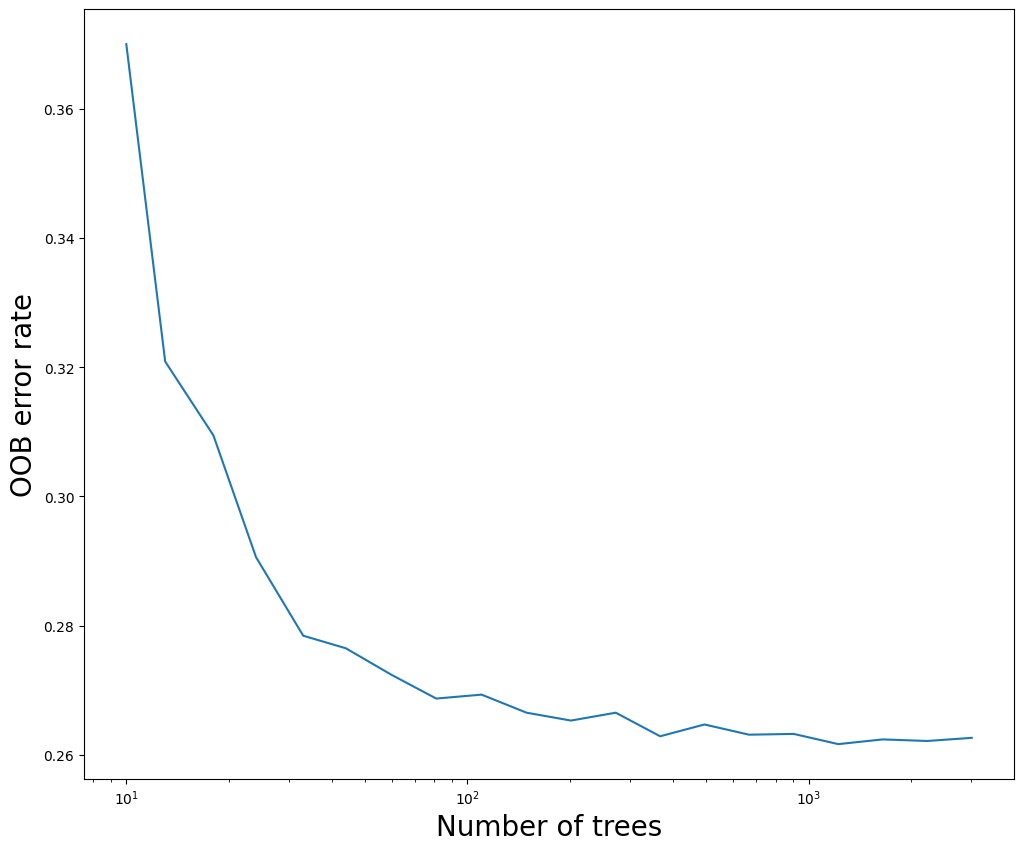

In [258]:
fig, ax = plt.subplots(figsize=(12,10))
ax.semilogx(list(oob_err_dict.keys()), list(oob_err_dict.values()))
ax.set_xlabel('Number of trees', fontsize=20)
ax.set_ylabel('OOB error rate', fontsize=20)
plt.show()

In [259]:
N_trees = 400
clf = RandomForestClassifier(n_estimators=N_trees, n_jobs=-1, max_depth=10, criterion='entropy')
model = clf.fit(X_train, y_train)
preds = model.predict(X_test)

In [260]:
import itertools

def plot_confusion_matrix(confusion_matrix, target_names, title='Confusion matrix',cmap=plt.cm.Blues, normalized=False):
    """
    This function prints and plots the confusion matrix
    """
    accuracy = np.trace(confusion_matrix) / np.sum(confusion_matrix).astype('float')
    misclass = 1 - accuracy
    fig, ax = plt.subplots(figsize=(15,10))
    
    if normalized == True:
        confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
        confusion_matrix = np.round_(confusion_matrix, decimals=3)
    
    ax.imshow(confusion_matrix, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)

    thresh = confusion_matrix.max() / 2.
    for i, j in itertools.product(range(confusion_matrix.shape[0]), range(confusion_matrix.shape[1])):
        plt.text(j, i, confusion_matrix[i, j],
                 horizontalalignment="center",
                 color="white" if confusion_matrix[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    ax.grid(False)
    plt.show()

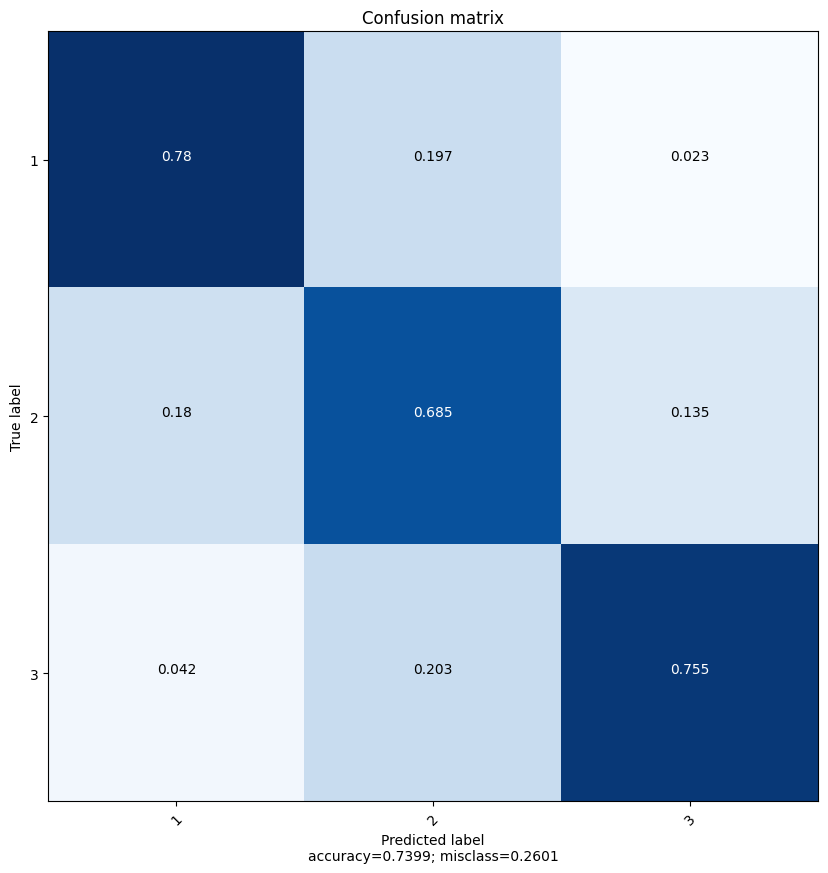

In [261]:
conf_matrix = confusion_matrix(y_test,model.predict(X_test))
target_names = [1,2,3]
plot_confusion_matrix(conf_matrix, target_names=class_names, title='Confusion matrix', normalized=True)

In [262]:
print("Recall:", conf_matrix[1][1]/(conf_matrix[1][1]+conf_matrix[1][0]))
print("Precision:", conf_matrix[1][1]/(conf_matrix[1][1]+conf_matrix[0][1]))

Recall: 0.792358803986711
Precision: 0.7781402936378466


In [263]:
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import AdaBoostClassifier


# define and train models

rf_model = RandomForestClassifier(n_estimators=N_trees, n_jobs=-1, max_depth=10, criterion='entropy', random_state=42).fit(X_train, y_train)
ab_model = AdaBoostClassifier(random_state=42).fit(X_train, y_train)

# make predictions
ab_preds = ab_model.predict(X_test)
rf_preds = rf_model.predict(X_test)




# compute performance metrics
def print_metrics(y_true, y_pred):

    cf = pd.DataFrame(
    columns=["Pred_1","Pred_2","Pred_3"],index=["True_1","True_2","True_3"])
    cf.loc[:,:] = confusion_matrix(y_true= y_true,y_pred= y_pred)
    print(cf/len(y_true))
    report =classification_report(y_true=y_true, y_pred=y_pred)
    print(report)


print("AdaBoost Metrics:")
print_metrics(y_test, ab_preds)

print("Random Forest Metrics:")
print_metrics(y_test, rf_preds)




AdaBoost Metrics:
          Pred_1    Pred_2    Pred_3
True_1  0.244531  0.084103  0.007292
True_2  0.049101  0.245503  0.043753
True_3  0.013126   0.06563  0.246962
              precision    recall  f1-score   support

         1.0       0.80      0.73      0.76       691
         2.0       0.62      0.73      0.67       696
         3.0       0.83      0.76      0.79       670

    accuracy                           0.74      2057
   macro avg       0.75      0.74      0.74      2057
weighted avg       0.75      0.74      0.74      2057

Random Forest Metrics:
          Pred_1    Pred_2    Pred_3
True_1  0.259601   0.06806  0.008264
True_2  0.062713  0.231891  0.043753
True_3  0.013126  0.067088  0.245503
              precision    recall  f1-score   support

         1.0       0.77      0.77      0.77       691
         2.0       0.63      0.69      0.66       696
         3.0       0.83      0.75      0.79       670

    accuracy                           0.74      2057
   macro a

In [264]:
# decision tree  on imbalanced dataset with SMOTE oversampling and random undersampling
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
# define dataset

# define pipeline
model = AdaBoostClassifier()
over = SMOTE(sampling_strategy="auto")
under = RandomUnderSampler(sampling_strategy="auto")
steps = [('over', over), ('under', under), ('model', model)]
pipeline = Pipeline(steps=steps)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X_train, Y_train, cv=cv, n_jobs=-1, error_score="raise", verbose=1)
print('Mean ROC AUC: %.3f' % mean(scores))
k_values = [1, 2, 3, 4, 5, 6, 7]
for k in k_values:
	# define pipeline
	model = AdaBoostClassifier()
	over = SMOTE(sampling_strategy="auto", k_neighbors=k)
	under = RandomUnderSampler(sampling_strategy="auto")
	steps = [('over', over), ('under', under), ('model', model)]
	pipeline = Pipeline(steps=steps)
	# evaluate pipeline
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(pipeline, X_train, Y_train, cv=cv, n_jobs=-1, error_score="raise", verbose=1)
	score = mean(scores)
	print('> k=%d, Mean ROC AUC: %.3f' % (k, score))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Mean ROC AUC: 0.332


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


> k=1, Mean ROC AUC: 0.335


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


> k=2, Mean ROC AUC: 0.334


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


> k=3, Mean ROC AUC: 0.335


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


> k=4, Mean ROC AUC: 0.334


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


> k=5, Mean ROC AUC: 0.333


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


> k=6, Mean ROC AUC: 0.333
> k=7, Mean ROC AUC: 0.332


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.9s finished
